# Analysis of the Geant4 simulation of the NEBULA detector

In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

### Just some `matplotlib` and `seaborn` parameter tuning

In [2]:
axistitlesize = 26
axisticksize = 23
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

In [182]:
BUILDDIR = '../project_nebula/NEBULA_build/'
OUTDIR = './out/'

## 1. Load output data of NEBULA simulation

In [254]:
proj_files = np.array(os.listdir(BUILDDIR))
proj_mask = np.array(['RodData_' in f for f in proj_files])
proj_files = proj_files[proj_mask]

In [255]:
# Energy of neutrons ([E] = 1)
E = 300
# NEBULA ROD COUNT
nrows = 2
ncols = 10
cols = np.array(['Rod{}'.format(i+1) for i in range(nrows*ncols)])

# Read in data files from all threads
data = []
for f in proj_files:
    data.append(pd.read_csv(BUILDDIR + f, skiprows=24, names=cols))

data = pd.concat([d for d in data])

## 2. Distribution of the total deposited energy among rods

In [256]:
data_org = data.sum().values.reshape(ncols, nrows).T
cols_org = cols.reshape(ncols, nrows).T

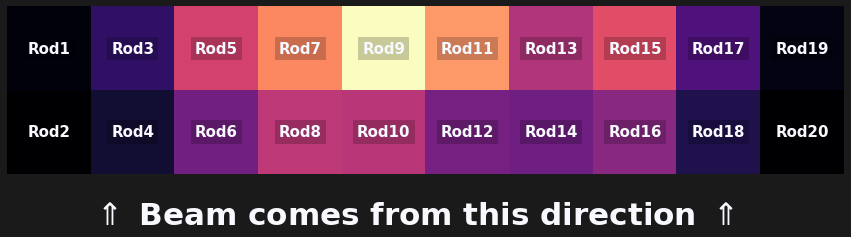

In [257]:
fig, axes = plt.subplots(figsize=(15,15),
                         facecolor='.1')
axes.set_aspect('equal')
axes.axis('off')

axes.matshow(data_org, cmap=cm.magma)
for X in range(cols_org.shape[0]):
    for Y in range(cols_org.shape[1]):
        axes.text(Y, X, cols_org[X, Y], fontsize=15,
                  ha='center', va='center', color='ghostwhite', fontweight='bold', 
                  bbox=dict(color=np.array((0,0,0,0.2)), lw=0)
                 )
plt.suptitle('$\\Uparrow$ Beam comes from this direction $\\Uparrow$',
             fontsize=axistitlesize+5, y=0.4, color='ghostwhite', fontweight='bold')

if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)
plt.savefig(OUTDIR + 'rod_heatmap_{0}.png'.format(E),
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')

plt.show()

## 3. Energy distribution of neutrons per rods

In [258]:
cols_hist = cols_org.flatten()

In [259]:
hist = {}
bins = {}
width = {}
center = {}

for c in cols_hist:
    hist[c], bins[c] = np.histogram(data[c][data[c] != 0], bins=10, density=True)
    width[c] = 0.8 * (bins[c][1] - bins[c][0])
    center[c] = (bins[c][:-1] + bins[c][1:]) / 2

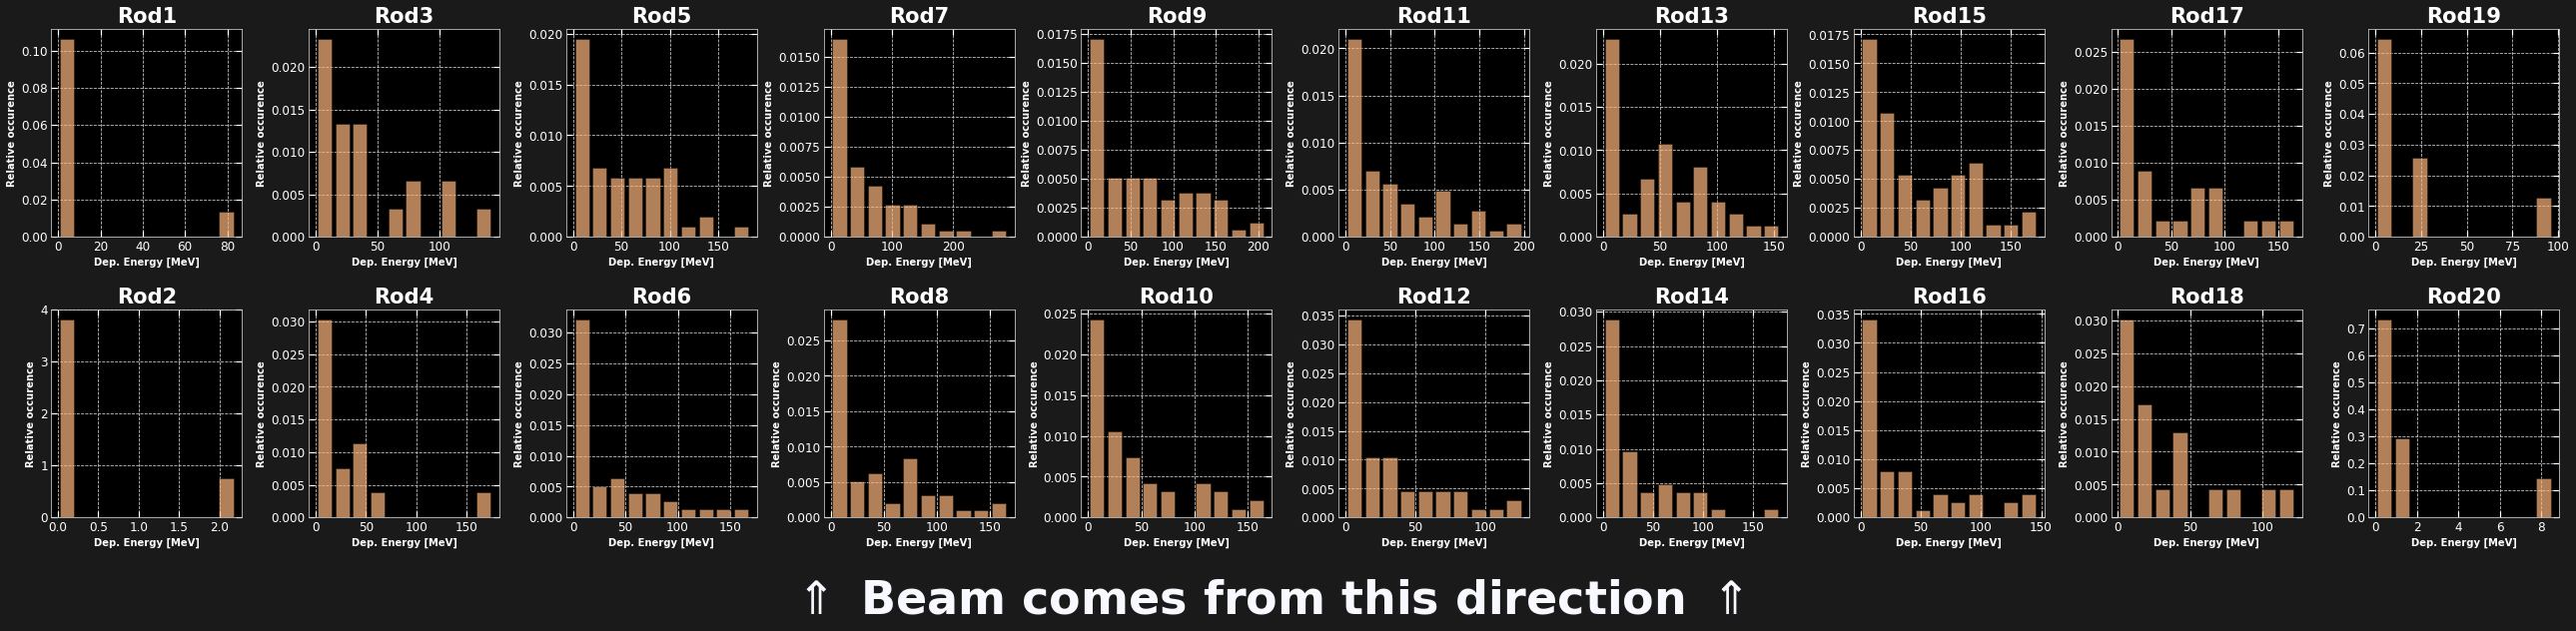

In [260]:
ncols = 10
nrows = (cols_hist.size+ncols-1)//ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.5, nrows*4.5),
                         facecolor='.1', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.35, wspace=0.35)

color = cm.magma(0.85)
# Loop through axes/rods
for col_i, ax in enumerate(axes.reshape(-1)):
    # Turn off all surplus axes
    if col_i < cols_hist.size:
        col = cols_hist[col_i]
        #ax.set_yscale('log')
        ax.bar(center[col], hist[col], width=width[col],
               color=color, alpha=0.7,
               ec='black', lw=0.5, align='center')
        ax.set_title(col, fontsize=axistitlesize-5, fontweight='bold', color='white')
        ax.set_xlabel('Dep. Energy [MeV]', fontsize=10, fontweight='bold', color='white')
        ax.set_ylabel('Relative occurence', fontsize=10, fontweight='bold', color='white')
        ax.tick_params(axis='both', which='major', labelsize=12, colors='white')

    else : ax.axis('off')

plt.suptitle('$\\Uparrow$ Beam comes from this direction $\\Uparrow$',
             fontsize=axistitlesize+20, y=0.03, color='ghostwhite', fontweight='bold')

if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)
plt.savefig(OUTDIR + 'energy_dist_per_rod_{0}.png'.format(E),
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')

plt.show()

## 4. Distribution of energy deposit for neutrons

In [261]:
data_hist = np.array(data).flatten()
hist, bins = np.histogram(data_hist[data_hist != 0], bins=10, density=True)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

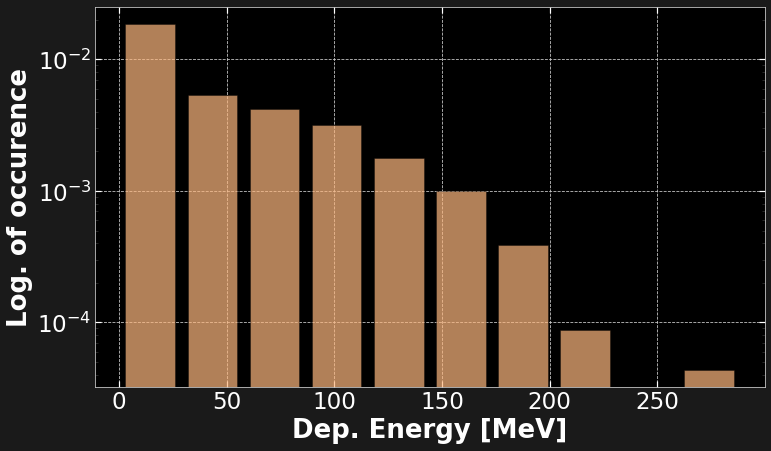

In [262]:
fig, axes = plt.subplots(figsize=(12, 7),
                         facecolor='.1', subplot_kw={'facecolor' : 'black'})

color = cm.magma(0.85)
axes.set_yscale('log')

axes.bar(center, hist, width=width,
         color=color, alpha=0.7,
         ec='black', lw=0.5, align='center')
axes.set_xlabel('Dep. Energy [MeV]', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('Log. of occurence', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

plt.show()